In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from pathlib import Path
from cellplot_package.cellplot.segmentation import rand_col_seg, plot_image_and_segmentation
from cellplot_package.cellplot.utils import generate_rainbow_colors
import re
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
import seaborn as sb
from matplotlib.lines import Line2D   

MARKER_NAMES = ['MPO', 'CD44', 'Fibronectin', 'CD11b', 'HLA-DR', 'PRPH', 'CXCR2', 'H3K9Ac', 'HLA-ABC', 'CD20', 'LUM', 'CD11c', 'CD24', 'CD3', 'CD45', 'CD8a', 'GD2', 'CD34', 'CD10', 'CXCR4', 'CD274', 'S100B', 'SOX10', 'FOXP3', 'CHGA', 'CD279', 'PNMT', 'H4K12Ac', 'GATA3', 'Ki-67', 'CD56', 'CD4', 'IDO', 'GZMB', 'ELAVL4', 'CD14', 'clPARP', 'DNA1', 'DNA1', 'Vimentin', 'CD15', 'IF1', 'IF2', 'IF3']
colors = generate_rainbow_colors(len(MARKER_NAMES))

In [2]:
mask_path = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEWEST_RESULTS/refined_masks"
image_path = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEWEST_RESULTS/img"

masks = list(Path(mask_path).glob("*BM*.tif"))
images = list(Path(image_path).glob("*BM*.tif"))

chosen_sample = masks[11].stem

mask = [x for x in masks if chosen_sample in str(x)]
image = [x for x in images if chosen_sample in str(x)]

print(mask, image)

[PosixPath('/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEWEST_RESULTS/refined_masks/20220921_20220811_22-01713_BM_001.tif')] [PosixPath('/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEWEST_RESULTS/img/20220921_20220811_22-01713_BM_001.tif')]


In [3]:
marker_image = tifffile.imread(image).squeeze()
mask_image = tifffile.imread(mask).squeeze()

In [4]:
marker_image.shape, mask_image.shape

((44, 696, 696), (696, 696))

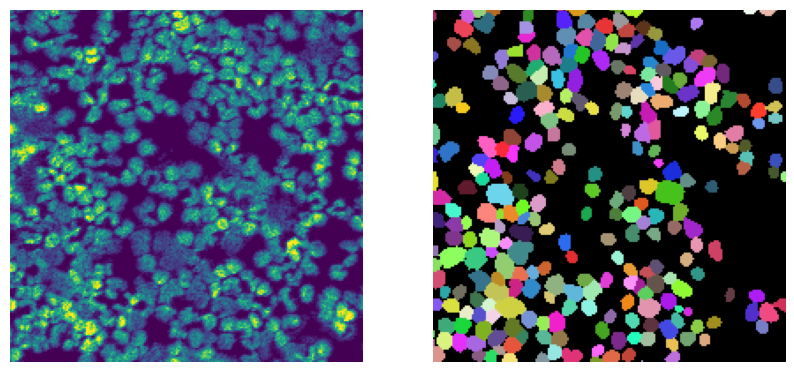

In [5]:
fig = plot_image_and_segmentation(marker_image[38, 50:250, 400:600], mask_image[50:250, 400:600])

In [6]:
from cellplot_package.cellplot.multiview import create_multiview

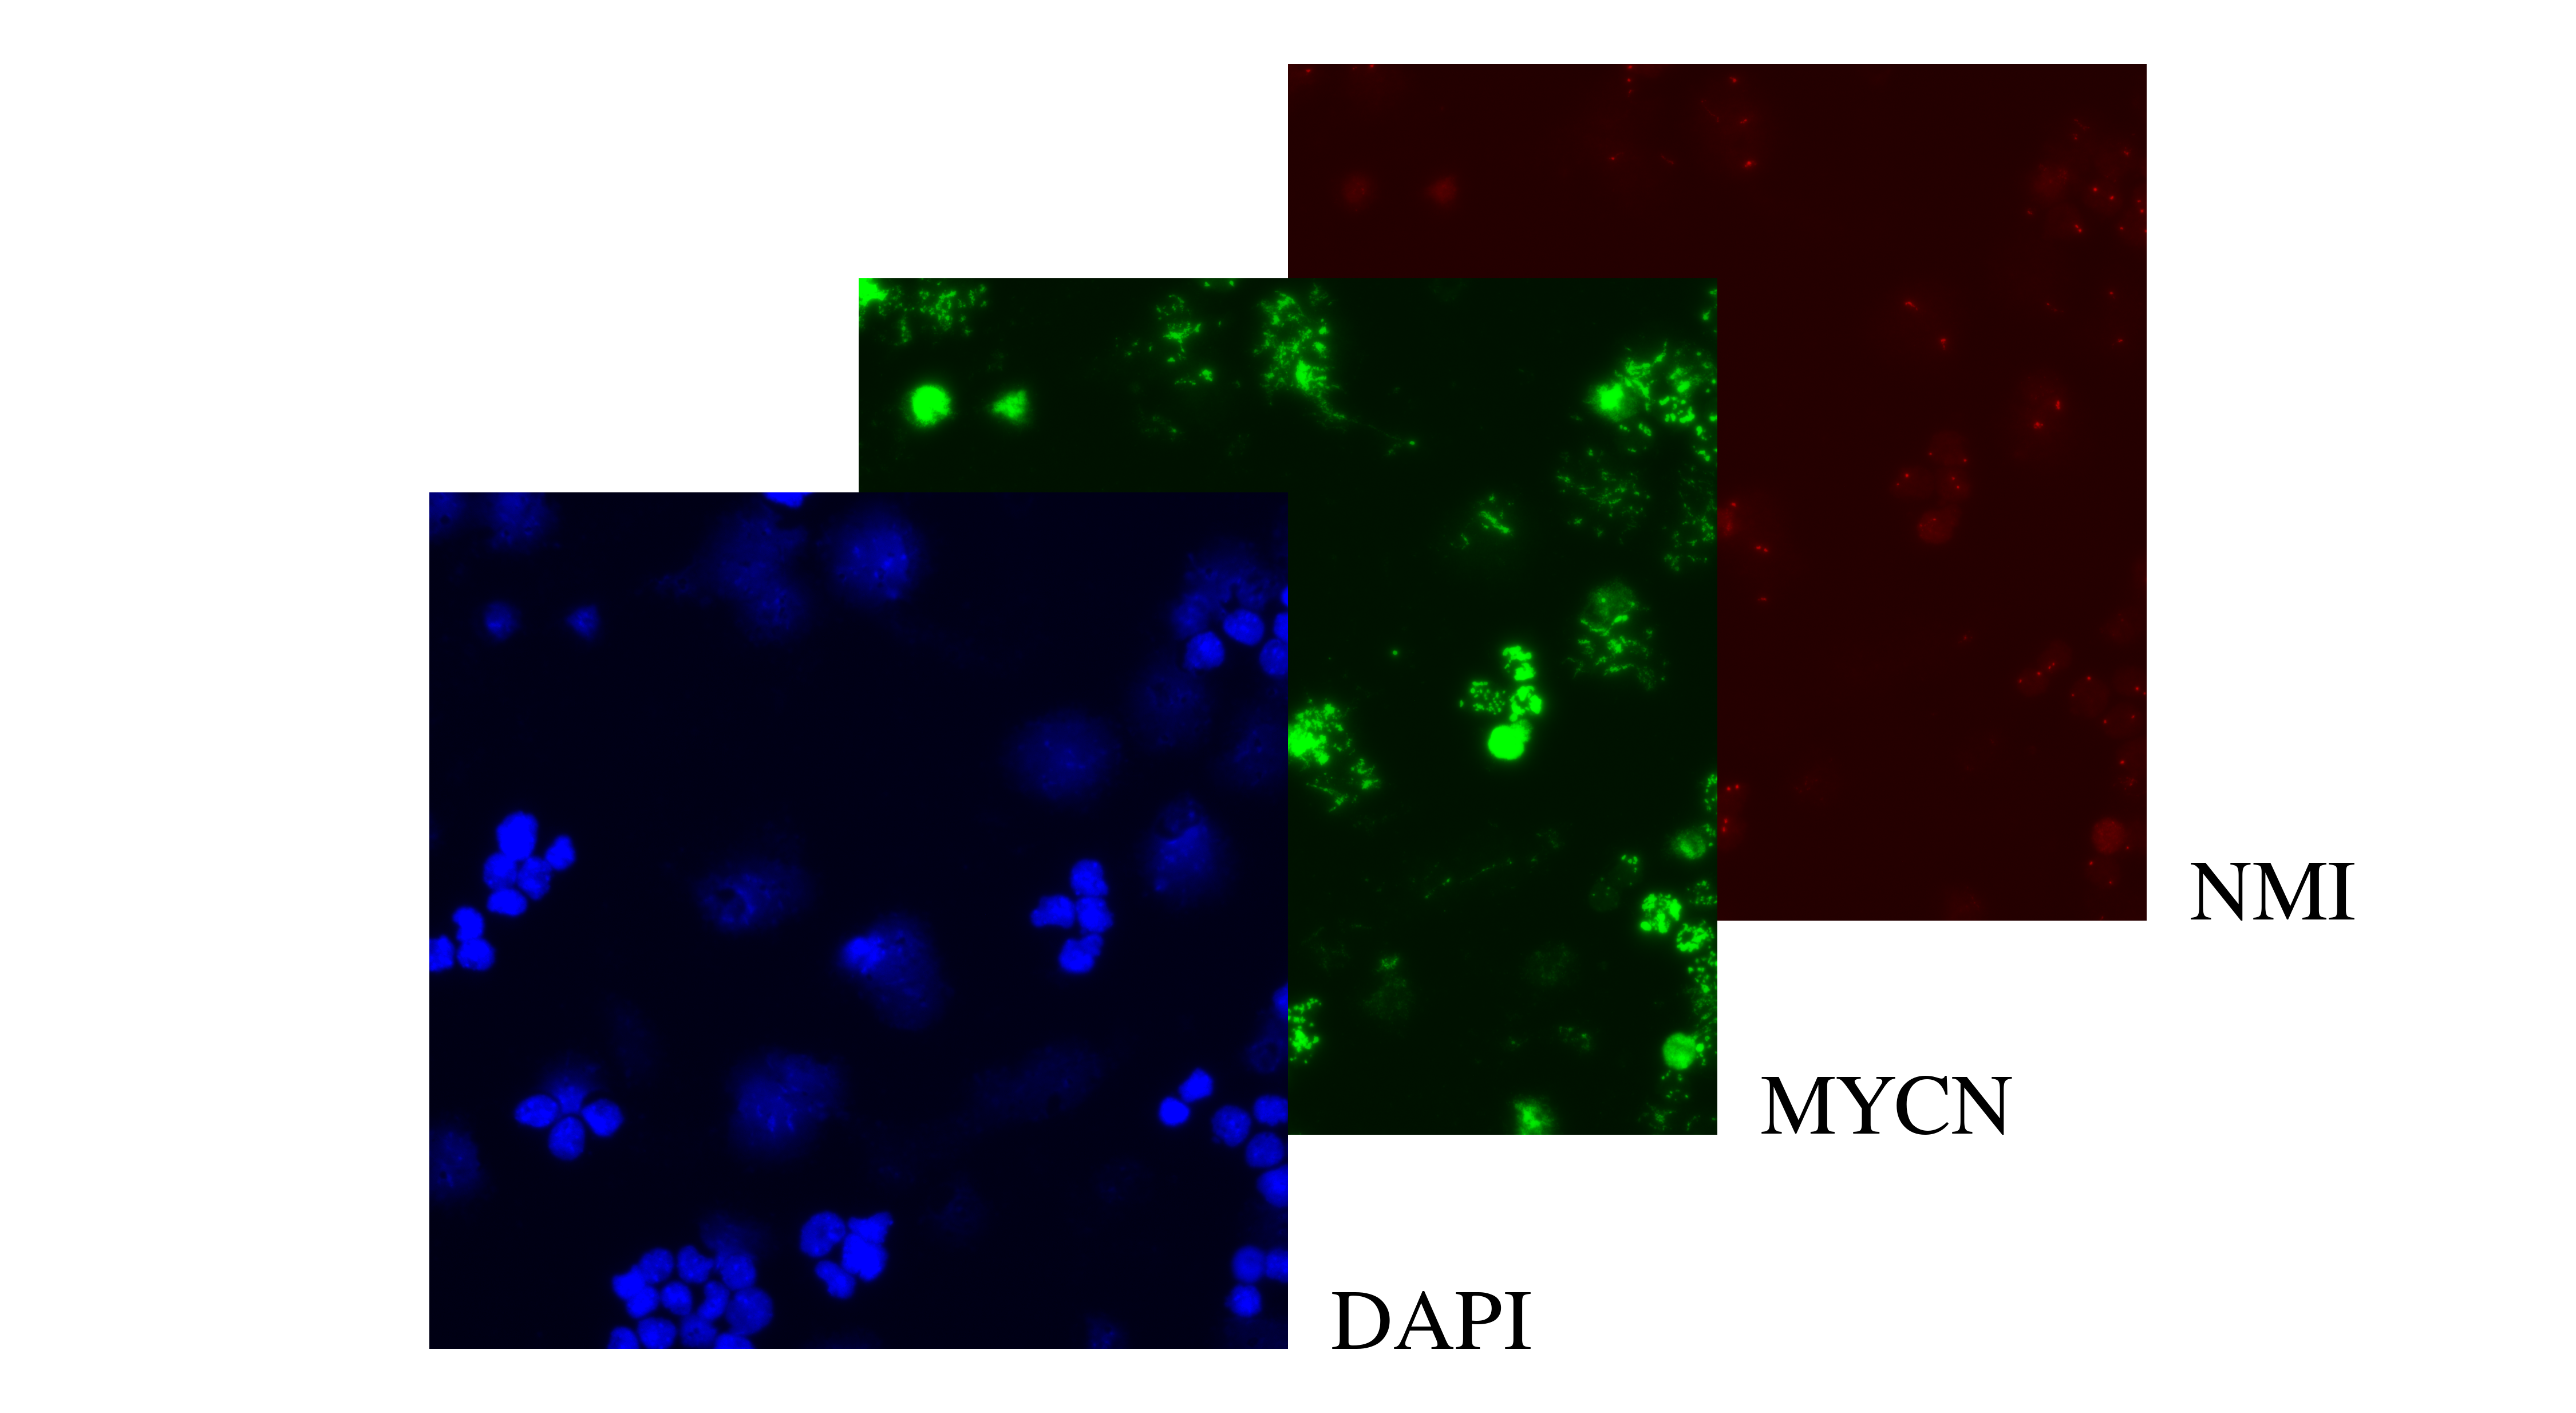

In [24]:
image = tifffile.imread("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/20230605_FISH/samples/SpikeIn-Christiane.S19/RGB/Img-000326.tif")[:1500, :1500]
canvas = create_multiview(image, channel_names=["NMI", "MYCN", "DAPI"], margins=(0.5, 0.1), shift=(0.5, 0.25), fontsize=150)
display(canvas)

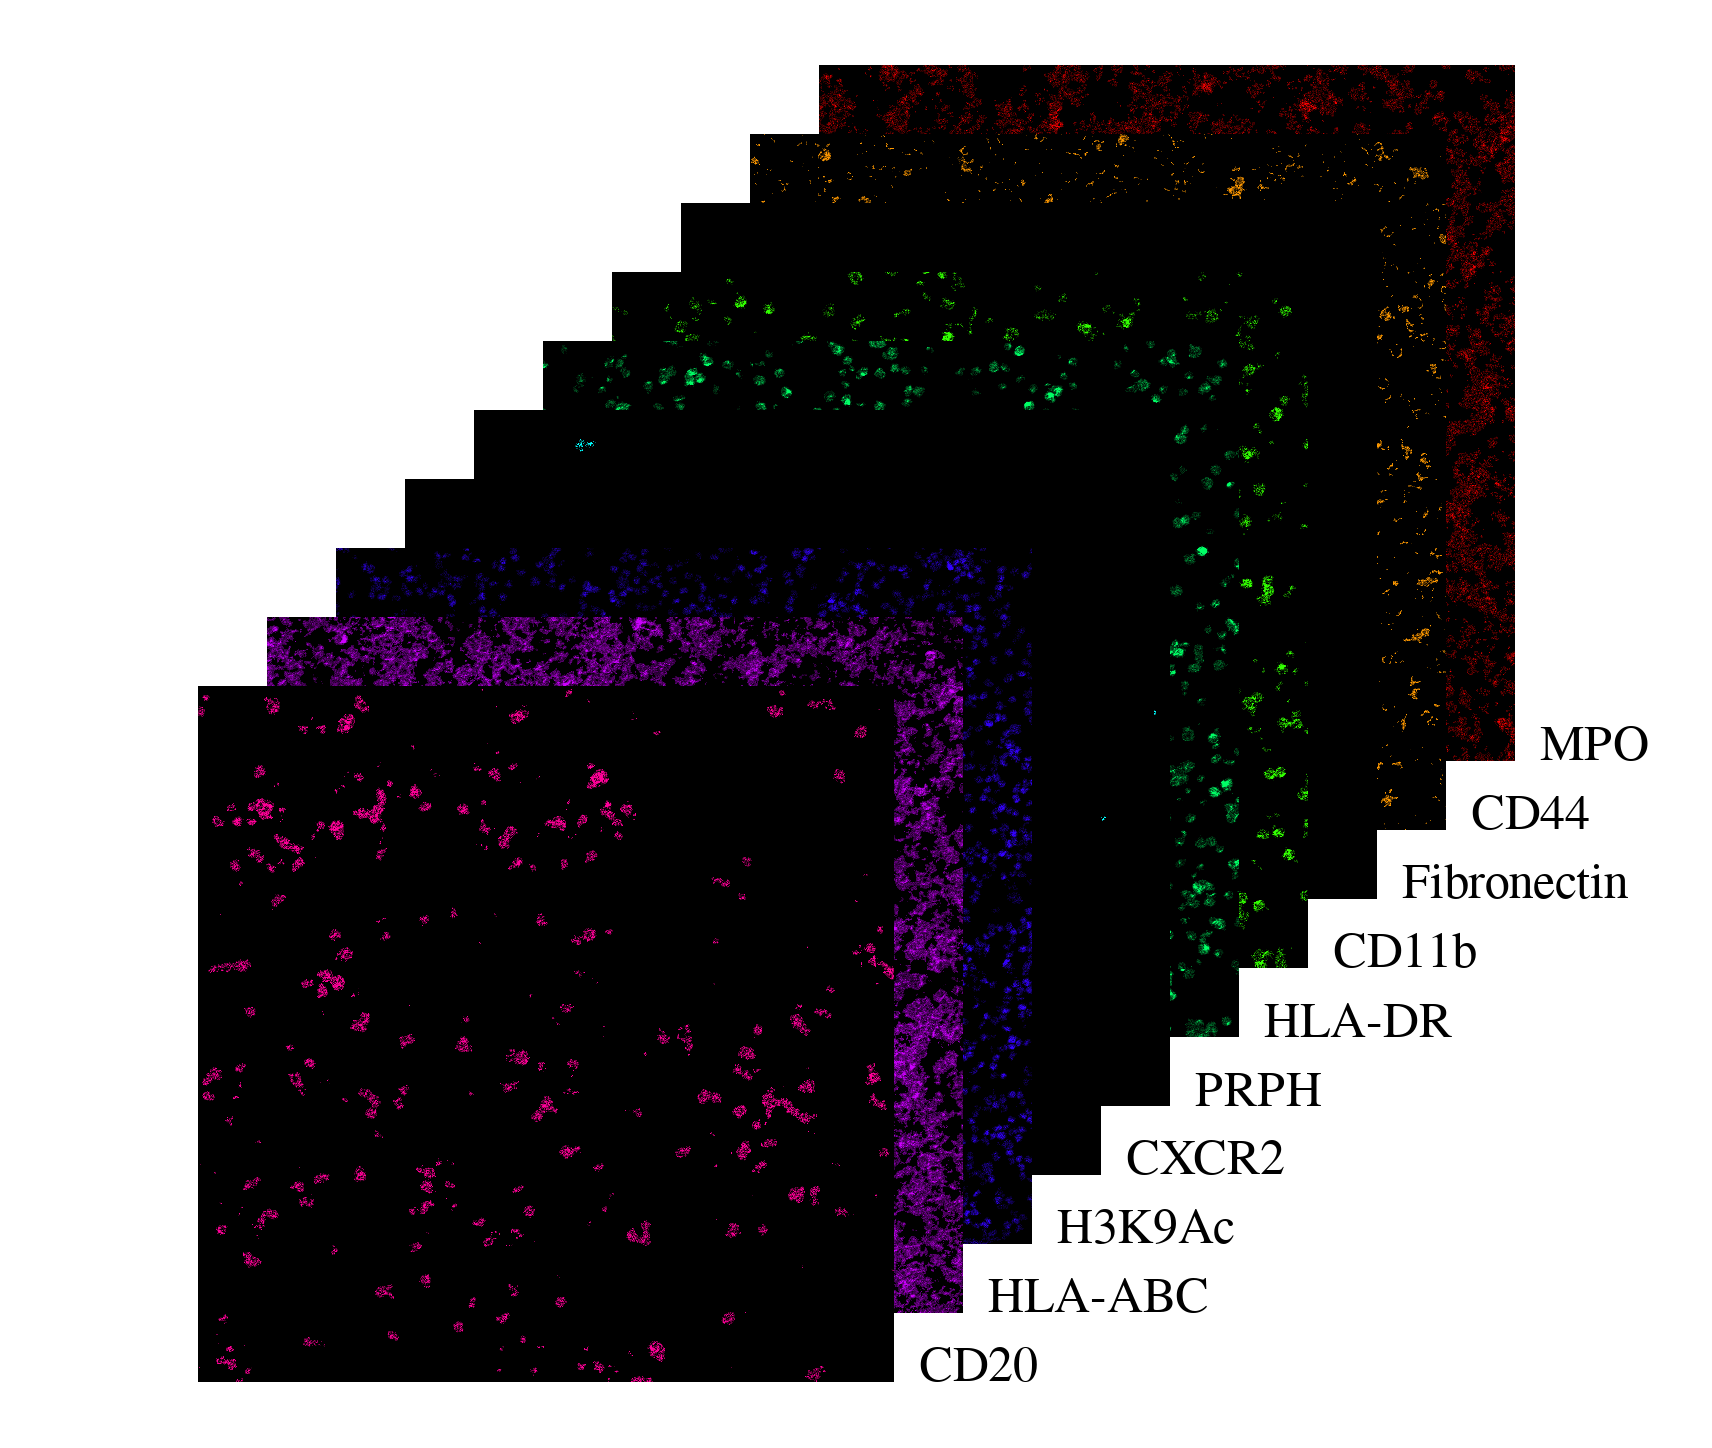

In [14]:
canvas = create_multiview(marker_image.transpose(1,2,0)[..., :10], channel_names=MARKER_NAMES[:10], margins=(0.3, 0.1), fontsize=50)
display(canvas)

In [ ]:
# Create a blank white image of size 600x600

def create_channel_plot(image, n_images=15, shift_x = 20, shift_y = 40, margin_x = 100, skip_channels = 5, fontsize=15):
    
    image_width = image.shape[1]
    image_height = image.shape[2]

    colors  = generate_rainbow_colors(n_images).tolist()
    canvas = Image.new('RGB', ((n_images-1)*shift_x + image_width + margin_x, (n_images-1)*shift_y + image_height), 'white')
    draw = ImageDraw.Draw(canvas)
    font = ImageFont.truetype("/usr/share/fonts/truetype/freefont/FreeSerif.ttf", fontsize)
    color = 'black'  # Text color

    for i in range(n_images):
        
        section = image[len(marker_names)-n_images+i-skip_channels].squeeze()
        
        colored_section = np.stack((section,)*3, axis=-1)
        
        
        draw.text((canvas.size[0]-i*shift_x - margin_x + 5, image_height+i*shift_y - shift_y//2), marker_names[len(marker_names)-n_images+i-skip_channels], fill=color, font=font, anchor="lm")
        color_array = np.full(colored_section.shape, colors[i], dtype=np.uint8)
        processed_image = (colored_section * color_array).astype(np.uint8)
        final_image = Image.fromarray(processed_image)

        canvas.paste(final_image, (canvas.size[0]-image_width-i*shift_x - margin_x, i*shift_y))
        
    return canvas
        
canvas = create_channel_plot(marker_image[:, 50:250, 400:600])

In [ ]:
canvas

In [ ]:
canvas.save("/home/simon_g/tmp/channel_view.eps")

In [ ]:
from CellPatchExtraction.src.extraction import extract_and_pad_objects
from scipy.ndimage import zoom

In [ ]:
patch_size = 32
target_size = 512
factor = target_size / patch_size 
zoom_factors_image = [1, factor, factor, 1]
zoom_factors_mask = [1, factor, factor]

colors = np.array([
    (255, 255, 0),      
    (128, 255, 255),    
    (0, 0, 255),      
    (0, 255, 0),  
    (255, 0, 0),
    (200, 0, 200)
])
        
idxs = [1, 8, 38, 9, 13, 20]  

patch_id = 10

In [ ]:
## with surrounding

def rescale(arr, factors, order=0):
    arr = np.array(arr)
    arr = np.clip(zoom(arr, factors, order=order), 0, 1)
    return arr
    
    
def get_mean_expression(mask, image):
    
    masks = np.stack((mask,)*image.shape[0], axis=0)
    channel_vals = image[masks==1].reshape(image.shape[0], -1)
    channel_vals = np.sort(channel_vals, axis=1)
    l = channel_vals.shape[1]
    mean = np.mean(channel_vals[:, int(l*0.8):], axis=1)
    print(int(l*0.8), l, mean)
    #mean_expression = np.expand_dims(np.mean(channel_vals, axis=1),1)

    mean_expression = np.expand_dims(mean,1)
    return mean_expression

def create_expression_plot(expression):
    
    fig, ax = plt.subplots(1, 1, figsize=(1,len(expression)))
    sb.heatmap(expression, annot=True, ax=ax, cbar=False, cmap="viridis", annot_kws={"fontsize": 20})
    ax.axis("off")
    return fig

def create_multichannel_view(multichannel_array, idxs_to_plot, colors):
    
    overlay_image = np.zeros((*multichannel_array[0].shape, 3))

    for n, idx in enumerate(idxs_to_plot):
        
        for channel in range(3):  # Iterate over color channels
                overlay_image[:, :, channel] += multichannel_array[idx] * colors[n][channel] / 255
                
        if n == len(colors)-1:
            break
        
    return np.clip(overlay_image, 0, 1)


def create_single_cell_plots(multichannel_patch, mask, idxs, colors, marker_names, save=False, suffix=""):
    
    canvas = create_channel_plot(multichannel_patch, 44, shift_x=0, shift_y=512, margin_x=500, fontsize=100, skip_channels=0)
    
    mean_expression = get_mean_expression(mask, multichannel_patch)
    expression_fig = create_expression_plot(mean_expression)
    
    overlay = create_multichannel_view(multichannel_patch, idxs, colors)

    overlay_fig = plt.figure()   
    
    custom_lines = [Line2D([0], [0], color=tuple(c/255), lw=4) for i, c in enumerate(colors)]
    markers = [marker_names[i] for i in idxs]
    
    plt.imshow(np.clip(overlay, 0, 1))
    plt.legend(custom_lines, markers, prop={"weight": "bold", "size": 12})
    plt.axis("off")
    
    overlay_mask_fig = plt.figure()   
    plt.imshow(np.clip(overlay, 0, 1))
    plt.imshow(mask, alpha=0.8, cmap="gray")
    plt.legend(custom_lines, markers, prop={"weight": "bold", "size": 12})
    plt.axis("off")

    display(canvas)
    
    if save:
        expression_fig.savefig(f"/home/simon_g/tmp/single_cell_expression{suffix}.eps")
        canvas.save(f"/home/simon_g/tmp/single_cell_mask{suffix}.eps")
        overlay_mask_fig.savefig(f"/home/simon_g/tmp/single_cell_multiview_mask{suffix}.eps")
        overlay_fig.savefig(f"/home/simon_g/tmp/single_cell_multiview{suffix}.eps")

In [ ]:

image_patches, mask_patches, surrounding_patches, background_patches, coords = extract_and_pad_objects(mask=mask_image, image=marker_image.transpose(1,2,0), patch_size=patch_size, exclude_edges=True, use_surrounding=True)

image_patches = rescale(image_patches[patch_id:patch_id+1], zoom_factors_image)
mask_patches = rescale(mask_patches[patch_id:patch_id+1], zoom_factors_mask)

patches = np.array(image_patches).transpose(0,-1,1,2)

for p, m in zip(patches, mask_patches): 
    
    create_single_cell_plots(p, m, idxs, colors, marker_names=marker_names, suffix="_surr", save=True)
    
    
image_patches, mask_patches, surrounding_patches, background_patches, coords = extract_and_pad_objects(mask=mask_image, image=marker_image.transpose(1,2,0), patch_size=patch_size, exclude_edges=True, use_surrounding=False)

image_patches = rescale(image_patches[patch_id:patch_id+1], zoom_factors_image)
mask_patches = rescale(mask_patches[patch_id:patch_id+1], zoom_factors_mask)

patches = np.array(image_patches).transpose(0,-1,1,2)

for p, m in zip(patches, mask_patches): 
    
    create_single_cell_plots(p, m, idxs, colors,  marker_names=marker_names, suffix="_nosurr", save=True)

In [ ]:
plt.rcParams["figure.figsize"] = 10, 10

rgb_image = np.zeros((200, 200, 3))

markers = []

for i, c in enumerate(idxs):
    
    markers.append(marker_names[c])
    
    im = marker_image[c, 50:250, 400:600]
    
    if im.max() == 0 or "IF" in marker_names[c]:
        continue
    
    for chan in range(3):  # Iterate over color channels
        rgb_image[:, :, chan] += im * colors[i][chan] / 255
        
    if i == len(colors)-1:
        break
   

custom_lines = [Line2D([0], [0], color=tuple(c/255), lw=4) for i, c in enumerate(colors)]

plt.imshow(np.clip(rgb_image, 0, 1))
plt.legend(custom_lines, markers, prop={"weight": "bold", "size": 12})
plt.axis("off")
plt.savefig("/home/simon_g/tmp/multiuchannel_view.eps")

In [ ]:
image_patches, mask_patches, surrounding_patches, background_patches, coords = extract_and_pad_objects(mask=mask_image, image=marker_image.transpose(1,2,0), patch_size=patch_size, exclude_edges=True, use_surrounding=True)

image_patches = rescale(image_patches[:10], zoom_factors_image)
mask_patches = rescale(mask_patches[:10], zoom_factors_mask)
surrounding_patches = rescale(surrounding_patches[:10], zoom_factors_mask)

patches = np.array(image_patches).transpose(0,-1,1,2)

In [ ]:
mc_view = create_multichannel_view(patches[0], idxs, colors)


plt.imshow(mc_view)
plt.axis("off")
plt.savefig("/home/simon_g/tmp/0_neighborhood.eps")
plt.show()

plt.imshow(mask_patches[0])
plt.axis("off")
plt.savefig("/home/simon_g/tmp/0_cellmask.eps")
plt.show()

plt.imshow(surrounding_patches[0])
plt.axis("off")
plt.savefig("/home/simon_g/tmp/0_neighborhoodmask.eps")
plt.show()